# Audio Decomposition

In this homework we will explore NMF-based audio decomposition.

We are getting close to the final project, so I will be providing very little hand holding in this assignment.  I will simply give you broad tasks to accomplish without providing decomposed functions or answers.  It is up to you to verify that your code is working!

Please note that part of your grade will be on the readability and decomposition of your code, so make sure your code is clean and organized.  Part of your grade will also be on the clarity of your writing.  You should explain your thought process clearly and support your claims with appropriate plots.

Team member #1: Rafael Burger

Hours spent on hw: ____________

Team member #2: Bob Zeng

Hours spent on hw: ____________

In [18]:
%matplotlib inline

In [19]:
import numpy as np
import librosa as lb
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy.io as sio
import scipy.signal as spsig
import copy as cp
import soundfile as sf
from scipy.io.wavfile import write


### NMF (30 points)

In this section you will implement the NMF algorithm.  You should do the following:
- Calculate the STFT of the given audio file ('xylophone.mp3').
- Implement the NMF algorithm as described in class.
- Describe a suitable stopping criterion and justify your selection with logic and/or experimental plots.
- Run NMF on the magnitude STFT
- Visualize the estimated template and activation matrices.  Comment on the results.

### 1. Calculate STFT 
We will start by calculating the STFT of the given audio file. 

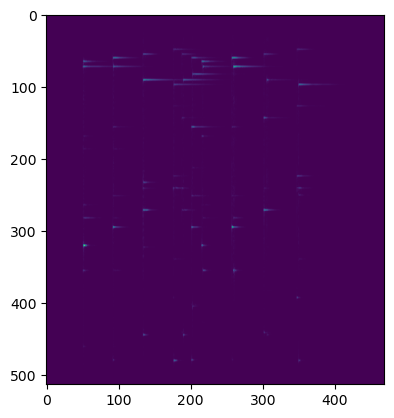

In [20]:
audio_file = 'xylophone.mp3'                                    # specify audio file
x, fs = lb.core.load(audio_file, sr = 22050)                    # unpack data from audio file

win_size = 1024                                                 # specify window size
hop_size = int(win_size / 2)                                    # specify hop size

f, t, S = spsig.stft(x, fs = fs, nperseg=win_size, noverlap=hop_size)

plt.imshow(np.abs(S))
plt.show()

### 2. Implement Non-negative Matrix Factorization
Now that we've computed the STFT for the given audio file, we can begin performing NMF. We'll start by initializing the W and H matrices. To do this, we need to think about what these matrices represent and therefore, what their dimensions should be. W is the "template matrix", so it should have a column for every template we are using to describe the given audio signal. H, the activation matrix, will have a row for each of these templates. We can determine the final two dimensions because we know that the product WH must have dimensions KxM (the dimensions of the STFT). 

Therefore, we have should initialize W and H with the following dimensions: 

W: K x R = 513 x 9

H: R x M = 9 x 469

Note that we have chosen R = 9 to represent 9 templates (one for each of the eight xylophone keys' tone and one for the percussive start to each key)

In this section, we will not include prior knowledge for the initialization for W and H, so we will initialize all entries to a non-negative, non-zero constant. 

In [21]:
### Allocate W(0), H(0) with the desired dimensions

K,M = S.shape               # define matrix dimensions
R = 8

W_naive_init = np.random.random_sample((K,R))
H_naive_init = np.random.random_sample((R,M))

In [22]:
### Implement NMF


epsilon = 10**-30

def updateH(V, W, H):
    H_1 = H * (W.T @ V) / ((W.T @ W @ H) + epsilon)
    return H_1

def updateW(V, W, H):
    W_1 = W * (V @ H.T) / ((W @ H @ H.T) + epsilon)
    return W_1

def NMF(V, W0, H0, num_iter):
    H_i = H0
    W_i = W0
    for i in range(num_iter):
        H_i = updateH(V = V, W = W_i, H = H_i)
        W_i = updateW(V, W = W_i, H = H_i)
    return (W_i, H_i)

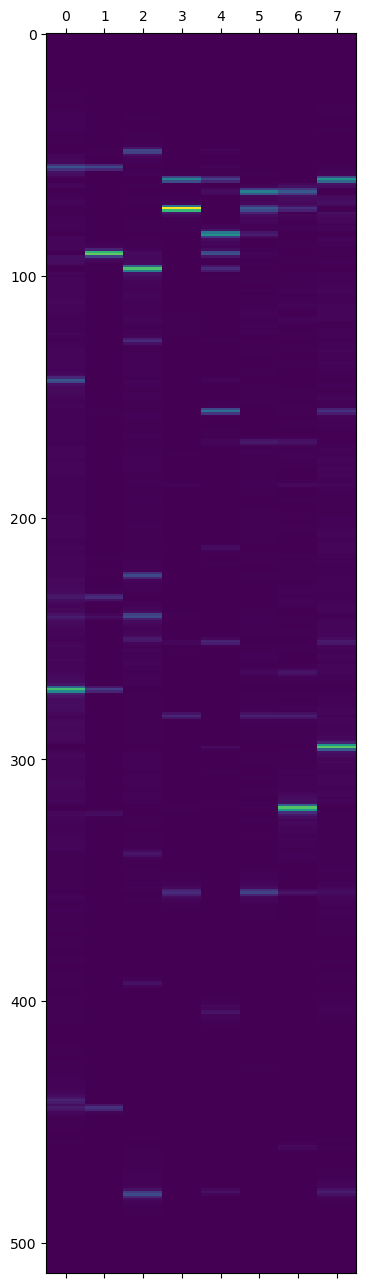

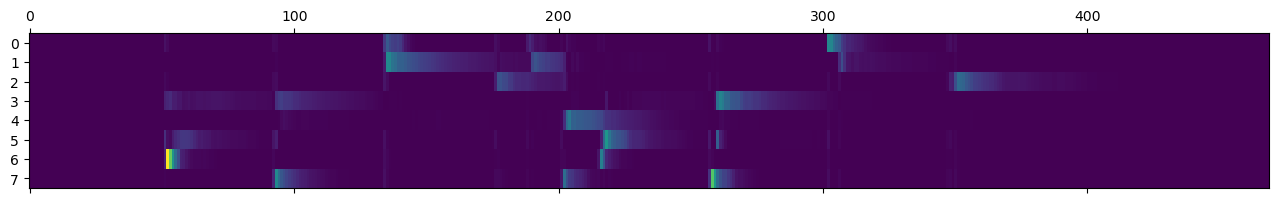

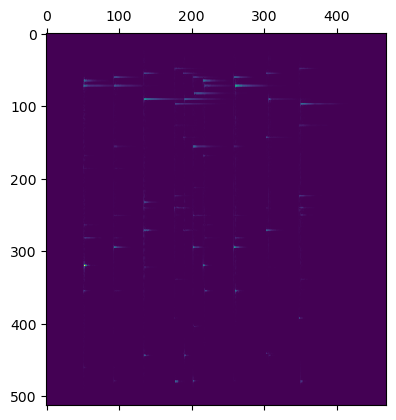

In [23]:
V = np.abs(S)
W_naive_trained = np.random.random_sample((K,R))
H_naive_trained = np.random.random_sample((R,M))
W, H = NMF(V = V, W0 = W_naive_init, H0 = H_naive_init, num_iter = 1000)

plt.matshow(W, aspect = 'auto')
plt.show()
plt.matshow(H, aspect = 'auto')
plt.show()
plt.matshow(V, aspect = 'auto')
plt.show()

### Reconstruction (15 points)

In this section you will reconstruct the audio for the estimated left and right hand tracks.  You should do the following:
- Implement the simple approach described in class
- Implement the soft masking approach described in class
- Listen to the results of both reconstruction methods.  Comment.

(8, 469)


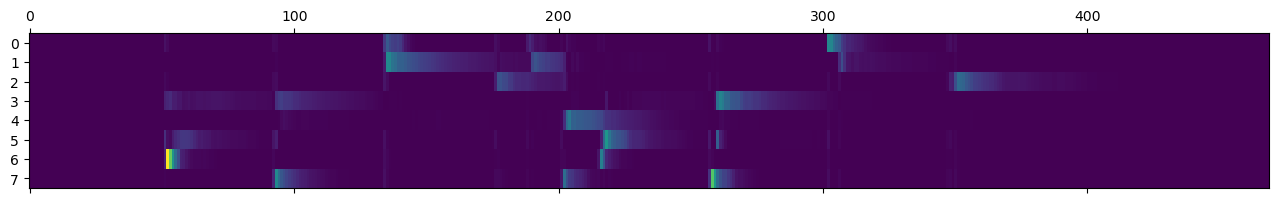

In [24]:
print(H.shape)
#print(H)
plt.matshow(H,aspect = 'auto')
plt.show()
#print(S)

In [25]:
#easy setup
H_L=cp.deepcopy(H)
H_R=cp.deepcopy(H)

H_L[0:3,:] = 0
H_R[4:8,:] = 0

WH_L = W@H_L
WH_R = W@H_R

S_imag=S.imag
S_imag=(S_imag*1j)

WH_L=np.add(WH_L,S_imag)
WH_R=np.add(WH_R,S_imag)

if np.array_equal(WH_L, WH_R):
    print("The matrices are the same.")
else:
    print("The matrices are not the same.")

The matrices are not the same.


In [26]:
#Apply istft
_, x_L = spsig.istft(WH_L, fs = fs, window='hann', nperseg=win_size, noverlap=hop_size)
_, x_R = spsig.istft(WH_R, fs = fs, window='hann', nperseg=win_size, noverlap=hop_size)

sf.write("out_left_easy.wav",x_L,22050)
sf.write("out_right_easy.wav",x_R,22050)

### Initializing templates (15 points)

In this section you will initialize the templates to incorporate prior knowledge.  You should do the following:
- Create a function that initializes a template matrix given a set of midi note numbers.  The templates should have random positive values around harmonic frequencies (+/- half a semitone), and zeros elsewhere.
- Visualize the initialized template matrix using the notes {C6, D6, E6, F6, G6, A6, B6, C7}.
- Run NMF with the initialized template matrix
- Visualize the resulting template and activation matrices.  Comment.
- Sonify the left and right hand tracks.  Comment.

In [27]:
### Define Functions to help with W(0) initialization

# define helper function to convert frequency to corresponding frequency bin


def getFreqBin(f, N, fs):
    return int(f * N/ fs)

# define function to create column of W(0) for a given note frequency
def calcTemplate(f0, K, N = 1024, f_margin = 3, fs = 22050):

    init_val = 1 # initial value to populate nonzero entries with

    if f0 == 0: # percussive template case

        template = np.random.random_sample((K,)) + 0.1

    else: # note template case   

        template = np.zeros((K,))

        harmonic_num = 1
        f_i = f0
        f_low = f_i- harmonic_num * f_margin # create high and low boundaries to set nonzero to account for note tuning inaccuracies
        f_high = f_i + harmonic_num * f_margin
        k_low = getFreqBin(f_low, N=N, fs = fs)  # compute the STFT frequency bin indices corresponding to the low and high frequency limits
        k_true = getFreqBin(f_i, N = N, fs = fs)
        k_high = getFreqBin(f_high, N=N, fs = fs)

        while k_low < K:    # as long as k_low in range, add the next harmonic 

            if k_low < 0: # account for case where k_low out of range but k_high in range
                k_low = 0

            if k_high >= K: # account for case where k_low is in range and k_high is out of range
                k_high = K-1

            if k_high - k_low < 1: ## account for case where k_high-k_low is too small to show up on matrix indices
                k_high = k_low + 1
            
            
            template[k_low:k_high] = np.random.random_sample((int(k_high-k_low),)) + 0.1 # assign initialization value to the frequency bins surrounding the current harmonic

            harmonic_num = harmonic_num + 1             # increment harmonic counter
            f_i = harmonic_num * f0                     # compute frequency of next harmonic
            f_low = f_i - harmonic_num * f_margin       # compute high and low error limits for new harmonic
            f_high = f_i + harmonic_num * f_margin
            k_low = getFreqBin(f_low, N=N, fs = fs)      # compute corresponding STFT frequency bin indices
            k_high = getFreqBin(f_high, N=N, fs = fs)
        
    return template

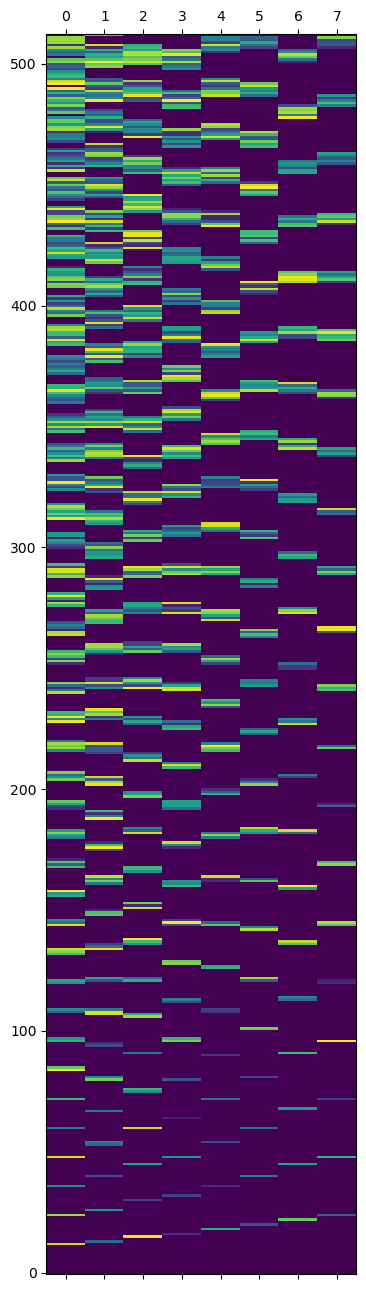

In [28]:
# define list of note frequencies [C4, D4, ... ,B4, C5]
f0_list = np.array([261.63, 293.66, 329.63, 349.23, 392.00, 440.00, 493.88, 523.25])

W_prior_init = np.zeros((K, R))

for i in range(R):
    W_prior_init[:, i] = calcTemplate(f0 = f0_list[i], K = K)

plt.matshow(W_prior_init, aspect = 'auto', origin = 'lower')
plt.show()

### Initializing Activations (10 points)

In this section you will initialize the activations to incorporate prior knowledge.  You may assume that you have already aligned the score and the audio, and have predicted the following note events at the following times.  You should do the following:
- Create a function that initializes an activation matrix given the note event information.  The entries should have random positive values around the note onsets, and zeros elsewhere.  You may assume a fixed note duration of 1 sec.
- Visualize the initialized activation matrix
- Run NMF with the initialized template and activation matrices
- Visualize the resulting template and activation matrices. Comment.
- Sonify the left and right hand tracks. Comment.

In [29]:
noteEvents = [(3, 1.23), (4, 1.23), (2, 2.19), (4, 2.19), (1, 3.16), (6, 3.16), 
              (0, 4.12), (7, 4.12), (1, 4.42), (6, 4.42), (2, 4.72), (5, 4.72),
              (3, 5.05), (4, 5.05), (2, 6.02), (4, 6.02), (1, 7.05), (6, 7.05),
              (0, 8.11), (7, 8.11)]

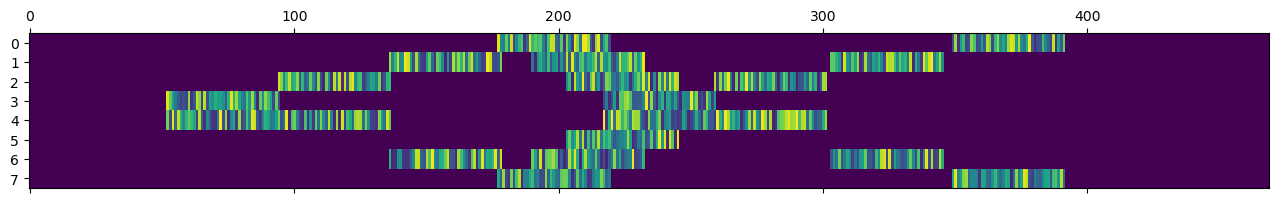

In [30]:
### INITIALIZE ACTIVATIONS TO INCORPORATE PRIOR KNOWLEDGE
H_prior_init = np.zeros((R, M))

def getAudioFrame(timestamp, fs, hop):
    audio_frame = timestamp * fs / hop
    return int(audio_frame)

for i in range(len(noteEvents)):
    template = noteEvents[i][0]
    timestamp = noteEvents[i][1]
    audio_frame = getAudioFrame(timestamp = timestamp, fs = fs, hop = hop_size)
    frame_duration = getAudioFrame(timestamp = 1, fs = fs, hop = hop_size)
    H_prior_init[template, audio_frame:audio_frame+frame_duration] = np.random.random_sample(frame_duration) + 0.1

plt.matshow(H_prior_init, aspect = 'auto')
plt.show()

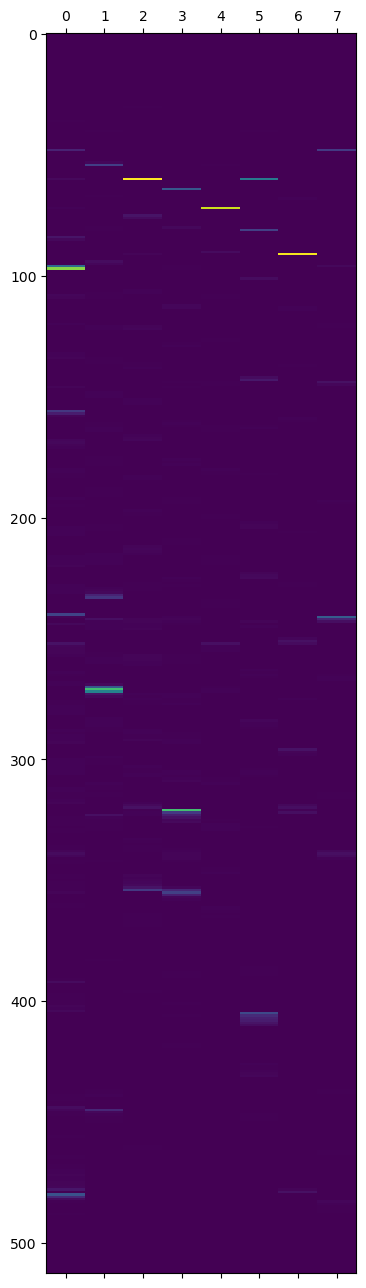

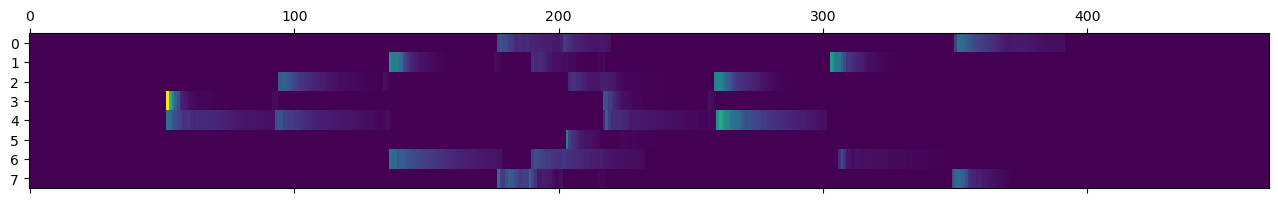

In [31]:
W_prior_trained, H_prior_trained = NMF(V = V, W0 = W_prior_init, H0 = H_prior_init, num_iter = 100)

plt.matshow(W_prior_trained, aspect = 'auto')
plt.show()
plt.matshow(H_prior_trained, aspect = 'auto')
plt.show()

### Onset Models (10 points)

In this section you will add onset models to your system.  You should do the following:
- Create a function that initializes a note & onset template matrix given a set of midi note numbers.  The note templates should have random positive values around harmonic frequencies, and zeros elsewhere.  The onset templates should have all random positive values.
- Create a function that initializes a note & onset activation matrix given the note event information.  The note activations should have random positive values for the interval (t_onset, t_onset+1.0), and zeros elsewhere.  The onset activations should have random positive values for the interval (t_onset - margin, t_onset + margin), and zeros elsewhere.
- Visualize the initialized template & activation matrices.
- Run NMF with the initialized template and activation matrices.
- Visualize the resulting template and activation matrices. Comment.
- Sonify the left and right hand tracks. Comment.